In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# 파일 다운로드

!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-03-20 13:58:43--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   201MB/s    in 0.3s    

2022-03-20 13:58:44 (201 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import shutil

if os.path.exists('/content/cats_and_dogs_filtered/'):    # 작업 디렉토리는 cats_and_dogs_filtered
    
    shutil.rmtree('/content/cats_and_dogs_filtered/')
    print('/content/cats_and_dogs_filtered/  is removed !!!')

In [4]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r') as target_file:

    target_file.extractall('/content/cats_and_dogs_filtered/') 

# ImageDataGenerator 이용하여 데이터 불러옴

In [30]:
train_data_gen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=10, width_shift_range=0.1, 
                                    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1)

val_data_gen = ImageDataGenerator(rescale=1./255)

In [31]:
train_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'

validation_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

In [32]:
IMG_WIDTH=224
IMG_HEIGHT=224

In [47]:
train_generator = train_data_gen.flow_from_directory(train_dir, batch_size=32, 
                                                color_mode='rgb', shuffle=True, 
                                                class_mode='binary',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))


validation_generator = val_data_gen.flow_from_directory(validation_dir, batch_size=32, 
                                              color_mode='rgb', shuffle=True, 
                                              class_mode='binary',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [48]:
# 정답 확인

print(train_generator.class_indices)
print(validation_generator.class_indices)

print(len(train_generator.classes))
print(len(validation_generator.classes))

print(train_generator.num_classes)
print(validation_generator.num_classes)

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}
2000
1000
2
2


# Fine Tuning 위한 pre-trained model 정의 및 모델 구축

In [49]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [50]:
model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 16)                16400     
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,245,281
Trainable params: 3,223,393
No

In [51]:
# 모델 컴파일

model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

In [52]:
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,          # 5회 Epoch동안 개선되지 않는다면 종료
                             )


start_time = datetime.now()

hist = model.fit(train_generator, epochs=20, validation_data=validation_generator)

end_time = datetime.now()

print('elapsed time = ', end_time-start_time)

Epoch 1/20
63/63 [==============================] - 42s 610ms/step - loss: 0.6012 - accuracy: 0.7225 - val_loss: 0.6474 - val_accuracy: 0.6500
Epoch 2/20
63/63 [==============================] - 39s 624ms/step - loss: 0.2303 - accuracy: 0.9220 - val_loss: 0.2561 - val_accuracy: 0.8860
Epoch 3/20
63/63 [==============================] - 44s 696ms/step - loss: 0.1487 - accuracy: 0.9600 - val_loss: 0.1339 - val_accuracy: 0.9590
Epoch 4/20
63/63 [==============================] - 38s 607ms/step - loss: 0.1089 - accuracy: 0.9685 - val_loss: 0.0847 - val_accuracy: 0.9790
Epoch 5/20
63/63 [==============================] - 38s 607ms/step - loss: 0.0928 - accuracy: 0.9700 - val_loss: 0.0673 - val_accuracy: 0.9780
Epoch 6/20
63/63 [==============================] - 38s 604ms/step - loss: 0.0662 - accuracy: 0.9810 - val_loss: 0.0557 - val_accuracy: 0.9840
Epoch 7/20
63/63 [==============================] - 37s 588ms/step - loss: 0.0554 - accuracy: 0.9875 - val_loss: 0.0491 - val_accuracy: 0.9810

In [53]:
import matplotlib.pyplot as plt

plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

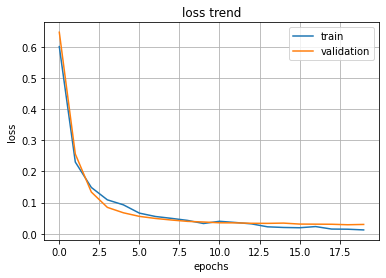

In [54]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()

# 테스트 이미지 확인

In [17]:
import zipfile

with zipfile.ZipFile('/content/test_dir.zip', 'r') as target_file:

    target_file.extractall('/content/test_dir/')

In [55]:
import cv2
import glob

test_img_list = []

test_img_name_list = glob.glob('/content/test_dir/*')

for i in range(len(test_img_name_list)):

    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    dst_img = dst_img / 255.0

    test_img_list.append(dst_img)

print(test_img_name_list)
print(len(test_img_list))

['/content/test_dir/test3.jpg', '/content/test_dir/test1.jpg', '/content/test_dir/test4.jpg', '/content/test_dir/test2.png', '/content/test_dir/test6.png', '/content/test_dir/test5.jpg']
6


In [56]:
plt.figure(figsize=(6,4))

for i in range(len(test_img_list)):

    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])

plt.show()

In [57]:
for i in range(len(test_img_list)):

    print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [58]:
# predict 수행하기 위해 batch 차원 추가
import numpy as np

print(np.array(test_img_list).shape)

(6, 224, 224, 3)


In [59]:
# predict 실행

class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

pred = model.predict(np.array(test_img_list))

print(pred.shape)
print(pred)

(6, 1)
[[4.3008330e-01]
 [2.3816629e-04]
 [9.9459320e-01]
 [1.2657145e-04]
 [9.9672580e-01]
 [9.7097462e-01]]


In [60]:
class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

plt.figure(figsize=(6,6))

for i in range(len(pred)):

    plt.subplot(2, 3, i+1)

    if pred[i] > 0.5:   # 정답이 1일 확률
        probility = pred[i]
    else:               # 정답이 0일 확률 
        probility = 1.0 - pred[i]

    title_str = str('{0:0.2f}'.format(100*max(probility))) + ' %'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_list[i])

plt.show()